In [1]:
### Import required libraries
import json
import numpy as np
import math
import pandas as pd
import slideio
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import torch
from torchvision import transforms
from PIL import Image
import cv2
from skimage.transform import resize
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import tifffile as tiff   # we want to write/handle our images as "TIFF"
import random

import glob
import os
from IPython.core.display import display, HTML
from pathlib import Path
# from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [2]:
### Some helper functions

def create_scene_info_table(scene):
    table = "<table style='border-collapse: collapse;'>"
    
    # Add table header row
    table += "<tr>"
    table += "<th style='border: 1px solid black; padding: 8px; text-align: left;'>Property</th>"
    table += "<th style='border: 1px solid black; padding: 8px; text-align: left;'>Value</th>"
    table += "</tr>"
    
    # Create rows for each property
    for property_name, value in [
        ("Name", scene.name),
        ("File Path", scene.file_path),
        ("Size (Width, Height)", scene.size),
        ("Number of Channels", scene.num_channels),
        ("Compression", scene.compression),
        ("Data Type", scene.get_channel_data_type(0)),
        ("Magnification", scene.magnification),
        ("Resolution", scene.resolution),
        ("Z-Resolution", scene.z_resolution),
        ("Time Resolution", scene.t_resolution),
        ("Number of Z-Slices", scene.num_z_slices),
        ("Number of Time Frames", scene.num_t_frames)
    ]:
        table += "<tr>"
        table += "<td style='border: 1px solid black; padding: 8px; text-align: left;'>{}</td>".format(property_name)
        table += "<td style='border: 1px solid black; padding: 8px; text-align: left;'>{}</td>".format(value)
        table += "</tr>"

    table += "</table>"
    return table

def show_scene_info(scene):
    table = create_scene_info_table(scene)
    # Display the HTML table
    display(HTML(table))

def show_image(image, max_size):
    width, height = image.shape[1], image.shape[0]
    aspect_ratio = width / height

    if width > height:
        new_width = max_size
        new_height = int(max_size / aspect_ratio)
    else:
        new_height = max_size
        new_width = int(max_size * aspect_ratio)

    # Check if the image has a single channel
    if image.ndim == 2:
        # Convert single-channel image to grayscale
        image = plt.cm.gray(image)

    fig, ax = plt.subplots(figsize=(new_width / 100, new_height / 100))
    ax.imshow(image)
    ax.axis('off')
    plt.show()

### We want to process all ".czi" files. For each file, we will generate and save 4096x4096 tiles for all "scenes".

In [3]:
# # Folder where all WSI ".czi" files exist
# dir_rawfiles = "/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/"

# # Folder where we want to save all extracted tiles
# dir_imgs = "/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/"

# # Get list of all patient WSIs
# wsi_img_list = (glob.glob(dir_rawfiles + "*.czi"))
# # wsi_img_list

# # Conversion parameters: selection of SVSJpegParameters as a parameter defines JPEG compression
# params = slideio.SVSJpegParameters()
# params.quality = 100 # compression quality

# ### if using JPEG2k - this creates issue in reading "svs" file
# # params = slideio.SVSJp2KParameters()
# # params.compression_rate = 4.5

# for i in range(1, 2):
    
#     # if i == 1:
#     #     break
    
#     # Get WSI filename w/o extension - we will use this to name folders
#     filename_noext = os.path.splitext(os.path.basename(wsi_img_list[i]))[0][-2:]
    
#     # Create unique folder for patient
#     parent_dir = dir_imgs
#     directory = filename_noext
#     path = os.path.join(parent_dir, directory)
    
#     if os.path.exists(path) == False:
        
#         print(f'Saving WSI: {filename_noext} for quantitative analysis ...')
#         os.mkdir(path)
    
#         ### Converting ".czi" to ".svs"
#         slide_czi = slideio.open_slide(wsi_img_list[i], "CZI")
#         num_scenes = slide_czi.num_scenes
    
#         for j in range(num_scenes):

#             scene = slide_czi.get_scene(j)
#             output_path = os.path.split(wsi_img_list[i])[0] + "/" + filename_noext + f"_scene_{j}.svs"
        
#             # Conversion to ".svs"
#             slideio.convert_scene(scene, params, output_path)
        
#             # Open converted file using "OpenSlide" library - this is because we want to use "DeepZoom" for tiling
#             slide_scene_svs = open_slide(output_path)
        
#             tile_sz = 4096
#             tiles = DeepZoomGenerator(slide_scene_svs, tile_size=tile_sz, overlap=0, limit_bounds=False)
#             num_levels = tiles.level_count
            
#             # Create folder for each tile level
#             for k in range(num_levels-1, num_levels):  # All levels will generate too may images
#                 cols, rows = tiles.level_tiles[k]
            
#                 # Saving image tiles at each level
#                 for row in range(rows):
#                     for col in range(cols):
#                         tile_name = os.path.join(path, '%s_%d_%d' % (f"sc_{j}", col, row))
#                         temp_tile = tiles.get_tile(k, (col, row))
#                         temp_tile_np = np.array(temp_tile.convert('RGB'))
#                         temp_tile_np = temp_tile_np[:, :, ::-1]    # BGR --> RGB
#                         # temp_tile_np[temp_tile_np > 170] = 255
#                         # plt.imsave(tile_name + ".png", temp_tile_np)
                    
#                         # image = tiff.imread(tile_name)
#                         # use SD to filter
#                         if (temp_tile_np.std() >= 30):
#                             tile_name_1 = os.path.join(path, '%s_%d_%d' % (f"sc_{j}", col, row))
#                             plt.imsave(tile_name_1 + ".png", temp_tile_np)
#                         else:
#                             pass
#                             # tile_name_2 = os.path.join(path_level_seg_2, '%s_%d_%d' % (filename_noext, col, row))
#                             # plt.imsave(tile_name_2 + ".png", temp_tile_np)
            
#         print(f'WSI: {filename_noext} imageset created !')
#     else:
#         print('Folder already exists !!')

### Saving patches from converted "svs" files

In [5]:
# Folder where all WSI ".czi" files exist
dir_rawfiles = "/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides_converted_svs/"

# Folder where we want to save all extracted tiles
dir_imgs = "/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/"

# Get list of all patient WSIs
wsi_img_list = (glob.glob(dir_rawfiles + "*.svs"))
# wsi_img_list

for i in range(len(wsi_img_list)):
    
    # if i == 1:
    #     break
    
    # Get WSI filename w/o extension - we will use this to name folders
    filename_noext = os.path.splitext(os.path.basename(wsi_img_list[i]))[0]
    
    # Create unique folder for patient
    parent_dir = dir_imgs
    directory = filename_noext
    path = os.path.join(parent_dir, directory)
    
    # check if directory exists already - if so don't create new directory
    if os.path.exists(path) == False:
        
        print(f'Saving WSI: {filename_noext} for quantitative analysis ...')
        os.mkdir(path)

        # Create sub-folders for different tile levels
        # Read WSI image
        slide = open_slide(wsi_img_list[i])
    
        tile_sz = 4096
        tiles = DeepZoomGenerator(slide, tile_size=tile_sz, overlap=0, limit_bounds=False)
        num_levels = tiles.level_count
        
        # Create folder for each tile level
        for k in range(num_levels-1, num_levels):  # All levels will generate too may images
            cols, rows = tiles.level_tiles[k]
            
            # Saving image tiles at each level
            for row in range(rows):
                for col in range(cols):
                    tile_name = os.path.join(path, '%s_%d_%d' % (f"sc_{filename_noext[-1]}", col, row))
                    temp_tile = tiles.get_tile(k, (col, row))
                    temp_tile_np = np.array(temp_tile.convert('RGB'))
                    temp_tile_np = temp_tile_np[:, :, ::-1]    # BGR --> RGB
                    temp_tile_np[temp_tile_np == 255] = 200
                    # plt.imsave(tile_name + ".png", temp_tile_np)
                    
                    # image = tiff.imread(tile_name)
                    # use SD to filter
                    if (temp_tile_np.std() >= 30):
                        tile_name_1 = os.path.join(path, '%s_%d_%d' % (f"sc_{filename_noext[-1]}", col, row))
                        plt.imsave(tile_name_1 + ".png", temp_tile_np)
                    else:
                        pass
                        # tile_name_2 = os.path.join(path_level_seg_2, '%s_%d_%d' % (filename_noext, col, row))
                        # plt.imsave(tile_name_2 + ".png", temp_tile_np)

        print(f'WSI: {filename_noext} imageset created !')
    else:
        print('Folder already exists !!')

Saving WSI: 34_scene_2 for quantitative analysis ...


KeyboardInterrupt: 

In [14]:
# print(parent_dir)
# print(directory)
print(path)
print(filename_noext)

/Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/34_scene_2
34_scene_2


### Correcting grayish, zigzag artefact in "czi" slides

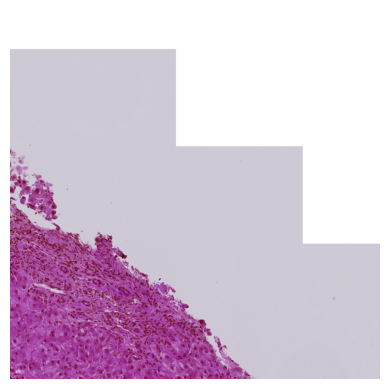

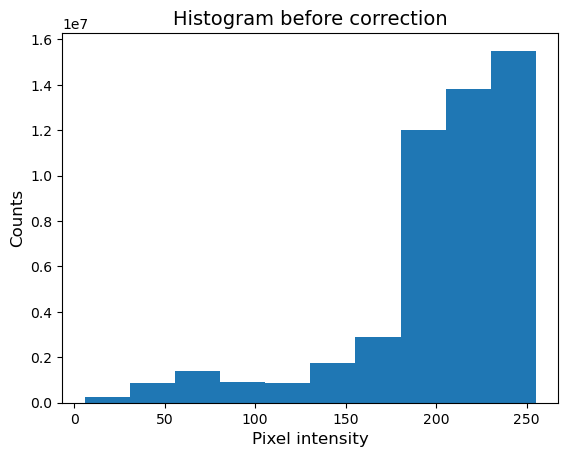

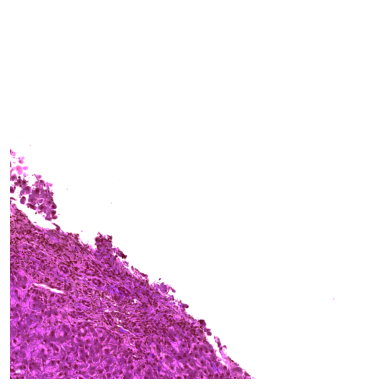

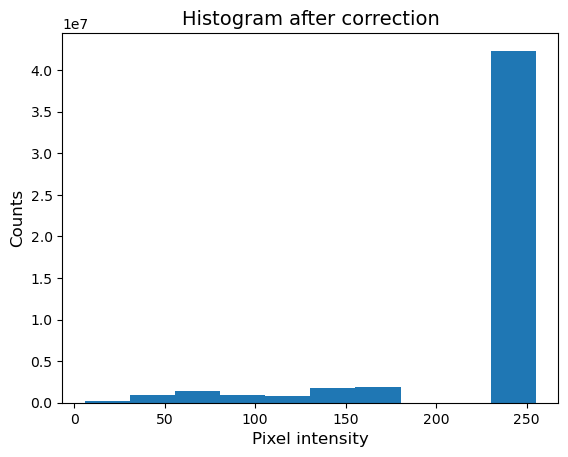

In [59]:
folder_main = "/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/44/"
imgs_list = glob.glob(folder_main + "*.png")
# imgs_list

k = np.random.randint(0, len(imgs_list), size=1)

region = Image.open(imgs_list[int(k)])
region = region.convert('RGB')
img = np.array(region)
img_m = img

plt.figure()
plt.imshow(img_m);
plt.axis('off')
# plt.savefig("/mnt/hd1/ani/Liver_pathology_project/Czi_correction/Before_corr_3.png")
plt.figure()
plt.hist(img_m.ravel());
plt.xlabel('Pixel intensity', fontsize=12);
plt.ylabel('Counts', fontsize=12);
plt.title('Histogram before correction', fontsize=14);
# plt.savefig("/mnt/hd1/ani/Liver_pathology_project/Czi_correction/Before_corr_hist_3.png")

# Change "gray" pixels to white
img_m[img_m > 170] = 255

plt.figure()
plt.imshow(img_m);
plt.axis('off')
# plt.savefig("/mnt/hd1/ani/Liver_pathology_project/Czi_correction/After_corr_3.png")
plt.figure()
plt.hist(img_m.ravel());
plt.xlabel('Pixel intensity', fontsize=12);
plt.ylabel('Counts', fontsize=12);
plt.title('Histogram after correction', fontsize=14);
# plt.savefig("/mnt/hd1/ani/Liver_pathology_project/Czi_correction/After_corr_hist_3.png")